In [2]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from numpy.random import randint
import random
import matplotlib.pyplot as plt
import seaborn as sb
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\francisco.neto\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\francisco.neto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\francisco.neto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\francisco.neto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
train_data = pd.read_csv('src/train_binary_small.csv')
test_data = pd.read_csv('src/test_binary_small.csv')

In [4]:
X_train = train_data["comment_text"]
y_train = train_data['Toxic']

In [5]:
X_test = test_data['comment_text']
y_test = test_data['Toxic']

In [6]:
X_test[0]

'== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.'

In [35]:
substitute = {
    "< br />":'',
    '<br />':'',
    "'ll":' will',
    "'s":' is',
    "'re":' are',
    "n't":' not'
}

In [36]:
def preprocessing(X, dict_change):
    new_x = []
    
    for i in X:
        text_lower = i.lower()
        
        for key in dict_change:
            if key in text_lower:
                text_lower.replace(key, dict_change[key])
        text_lower = re.sub("\W", ' ', text_lower)
        text_lower = re.sub(" +", ' ', text_lower)
        tokens = nltk.word_tokenize(text_lower)
        tokens = [x for x in tokens if x not in stopwords.words('english')]  
        new_x.append(' '.join(tokens))
    return new_x

def lemmatizer(X):
    lemmatizer = WordNetLemmatizer()
    new_x = []
    for i in X:
        tokens = nltk.word_tokenize(i)
        for j in range(len(tokens)):
            tokens[j] = lemmatizer.lemmatize(tokens[j])
        new_x.append(' '.join(tokens))
    return new_x


In [9]:
X_train = preprocessing(X_train, substitute)
X_test = preprocessing(X_test, substitute)

In [10]:
X_train[0]

'edits good cunts like revert good edits stupid understand write well revert edits decided bear playground grudge problem maybe one day realise damage noble project 201 215 187 159'

In [11]:
X_train = lemmatizer(X_train)
X_test = lemmatizer(X_test)

In [12]:
X_train[0]

'edits good cunt like revert good edits stupid understand write well revert edits decided bear playground grudge problem maybe one day realise damage noble project 201 215 187 159'

In [6]:
def training(X_train, y_train,X_test,y_test, method, models, random_state):
    df = {
        'Model': [],
        'Accuracy': []
    }    
    for model in models:
        pipeline = make_pipeline(method, models[model])
        clf = pipeline.fit(X_train, y_train)
        df['Model'].append(model)
        df['Accuracy'].append(accuracy_score(y_test, clf.predict(X_test)))

    return pd.DataFrame(df)

In [7]:
def optimized_training(X_train, y_train,X_test,y_test,method, models, params,random_state, n_iter):
    df = {
        'Model':[],
        'Params': [],
        'Accuracy': [],
    }
    transformer = method.fit(X_train)
    X_train = transformer.transform(X_train)
    X_test= transformer.transform(X_test)
    for model in models:
        clf = RandomizedSearchCV(models[model], params[model], n_iter=n_iter, n_jobs=-1)
        clf.fit(X_train, y_train)
        predict = clf.predict(X_test)
        df['Model'].append(model)
        df['Params'].append(clf.best_estimator_)
        df['Accuracy'].append(accuracy_score(y_test, predict))
    return pd.DataFrame(df)

In [15]:
models = {
    'MLP 1layer': MLPClassifier(max_iter=4000),
    'MLP 2layer': MLPClassifier(max_iter=4000),
    'SVC Linear': SVC(kernel='linear'),
    'SVC Poly': SVC(kernel='poly'),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision tree': DecisionTreeClassifier(),
}

In [16]:
dataframe = pd.DataFrame()
methods = [CountVectorizer(), TfidfVectorizer()]
for i in methods:
        dataframe_aux = training(X_train, y_train,X_test,y_test, i, models, 42)
        dataframe_aux['Method'] = f'{i}'
        dataframe = pd.concat([dataframe, dataframe_aux], ignore_index=True)

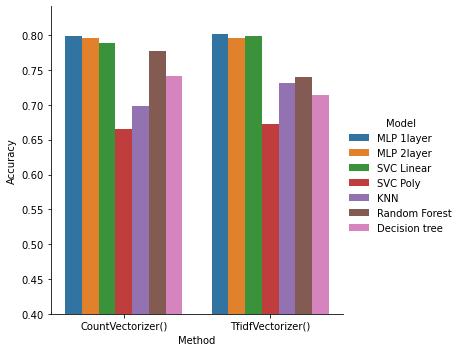

In [17]:
sb.catplot(data=dataframe, y='Accuracy', x='Method', hue='Model', kind='bar')
plt.ylim(0.4);

In [18]:
models = {
    'MLP 1layer': MLPClassifier(max_iter=4000),
    'MLP 2layer': MLPClassifier(max_iter=4000),
    'SVC Linear': SVC(kernel='linear')
}

In [19]:
C = [2 ** i for i in range(-5, 16,2)]
gamma = [2 ** i for i in range(-15, 4,2)]

In [20]:
gamma = random.choices(gamma, k=3)
gamma.append('scale')
gamma.append('auto')

In [21]:
C = random.choices(C, k=3)

In [22]:
params = {
    'SVC Linear': {'gamma':gamma, 'C':C },
    'MLP 1layer': {'hidden_layer_sizes':[(x, ) for x in range(2,1000)]},
    'MLP 2layer': {'hidden_layer_sizes':[(randint(50,1000), randint(50,1000)) for x in range(2,1000)]},
}

In [23]:
dataframe = pd.DataFrame()
methods = [CountVectorizer(), TfidfVectorizer()]
pre_processing = ['Basic Preprocessing', 'Lematization', 'add removing no words']
for i in methods:
        dataframe_aux = optimized_training(X_train,y_train,X_test,y_test,i,models,params,42,15)
        dataframe_aux['Method'] = f'{i}'
        dataframe = pd.concat([dataframe, dataframe_aux], ignore_index=True)

In [27]:
dataframe

,Model,Params,Accuracy,Method
0,MLP 1layer,"MLPClassifier(hidden_layer_sizes=(508,), max_i...",0.797333,CountVectorizer()
1,MLP 2layer,"MLPClassifier(hidden_layer_sizes=(309, 992), m...",0.813333,CountVectorizer()
2,SVC Linear,"SVC(C=8, gamma=0.001953125, kernel='linear')",0.786667,CountVectorizer()
3,MLP 1layer,"MLPClassifier(hidden_layer_sizes=(895,), max_i...",0.808000,TfidfVectorizer()
4,MLP 2layer,"MLPClassifier(hidden_layer_sizes=(813, 503), m...",0.813333,TfidfVectorizer()
5,SVC Linear,"SVC(C=8, gamma=0.001953125, kernel='linear')",0.801333,TfidfVectorizer()


In [ ]:
dataframe.to_csv('results',sep='\t')